In [1]:
from pathlib import Path

while Path.cwd().name != 'retrieval-model-safety':
    %cd ..

%matplotlib inline

/home/luiza_cohere_com/retrieval-model-safety


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt

sns.set(context="paper", style="white", font_scale=2.5, palette="tab10")

In [3]:
base_folder = Path(f"outputs/experiments")

## Alpha + Temperature experiments

In [41]:
varied_var = "alpha"
experiment_folder = base_folder / "alpha_temperature"
assert experiment_folder.exists()

metrics = ["perplexity", "toxicity", "diversity"]

In [42]:
metrics_dfs = {}
for metric in metrics:
    files = list(experiment_folder.rglob(f"*{metric}.csv"))
    metric_df = pd.DataFrame()
    for file in files:
        df = pd.read_csv(file, index_col=0)
        
        if metric == "toxicity":
            df = df.T.reset_index().melt(id_vars="index", value_name="value", var_name="metric").rename(columns={"index": "mode"})
            df = df.query("metric != 'std_max'")
            df["metric"] = df["metric"].map(
                {"avg_max": "Expected Maximum Toxicity", "toxicity_probability": "Toxicity Probability"}
            )

        if file.parent.name == 'baseline':
            df[varied_var] = np.nan
            df["temperature"] = np.nan
            df["dstore"] = "Baseline"
        else:
            df[varied_var] = float(file.parents[0].name.split("_")[-1])
            df["temperature"] = float(file.parents[3].name.split("_")[-1])
            df["dstore"] = file.parents[1].name
        
        df["dstore"] = df["dstore"].map({"both": "Toxic + Non-Toxic", "toxic": "Toxic", "Baseline": "Baseline"}) 
        metric_df = pd.concat([metric_df, df])
    if metric in ["perplexity", "diversity", "perplexity_ours"]:
        metric_df = metric_df.melt(var_name="mode", value_name="value", id_vars=[varied_var, "temperature", "dstore"])
    metrics_dfs[metric] = metric_df.reset_index(drop=True)

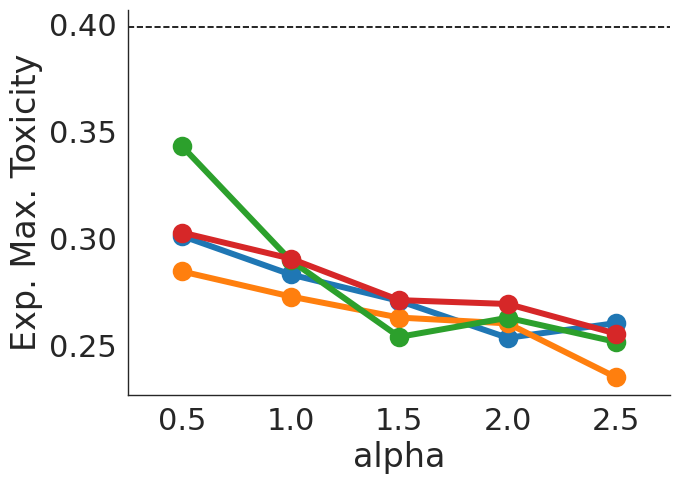

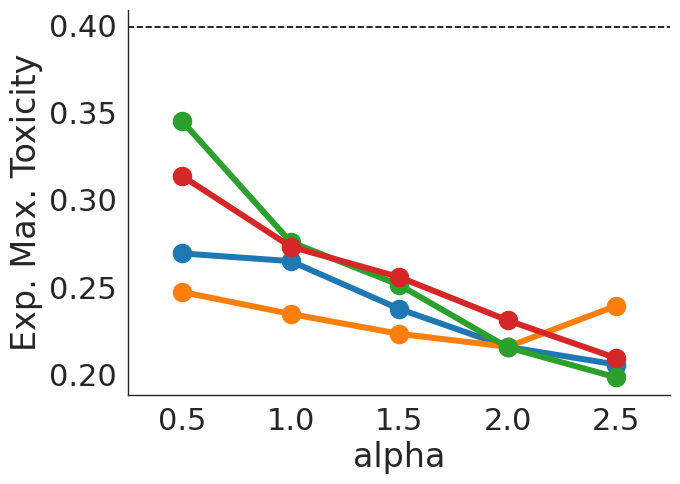

In [46]:
metric = "Expected Maximum Toxicity"

baseline = metrics_dfs["toxicity"].query("mode == 'nontoxic' and dstore == 'Baseline'").copy()
temp = metrics_dfs["toxicity"].query(f"mode == 'nontoxic' and dstore != 'Baseline'").copy()

for dstore in ["Toxic", "Toxic + Non-Toxic"]:
    plt.figure(figsize=(7, 5))
    g = sns.pointplot(
        data=temp.query("dstore == @dstore and metric == @metric"), 
        x="alpha", 
        y="value", 
        hue="temperature",
        scale=2.0
    )
    value = baseline[baseline["metric"] == metric]["value"].values[0]
    g.axhline(value, linestyle="--", color="black", label="GPT2 (large)")
    # g.text(2.5, value+value*0.01, "GPT2 (large)", fontdict={"fontsize": 16})

    sns.despine(right=True, top=True)
    plt.ylabel("Exp. Max. Toxicity")
    # plt.legend(frameon=False, title="temperature", loc="upper right", bbox_to_anchor=(1.5, 1.0))
    g.legend_.remove()
    plt.savefig(f"images/alpha_temperature_toxicity_{dstore.replace('+', '_').replace(' ', '_')}.pdf", bbox_inches="tight")
    plt.show()

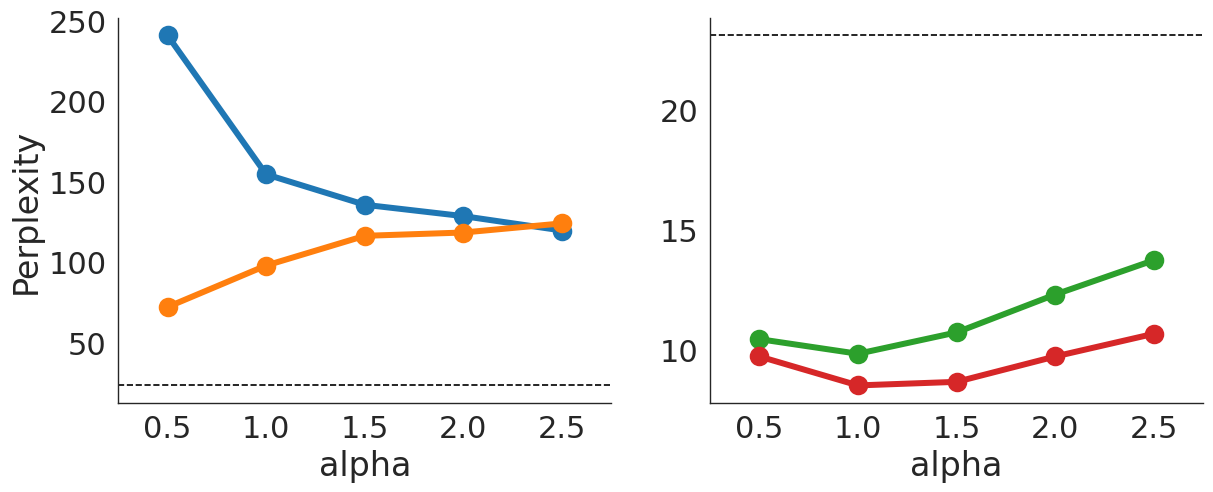

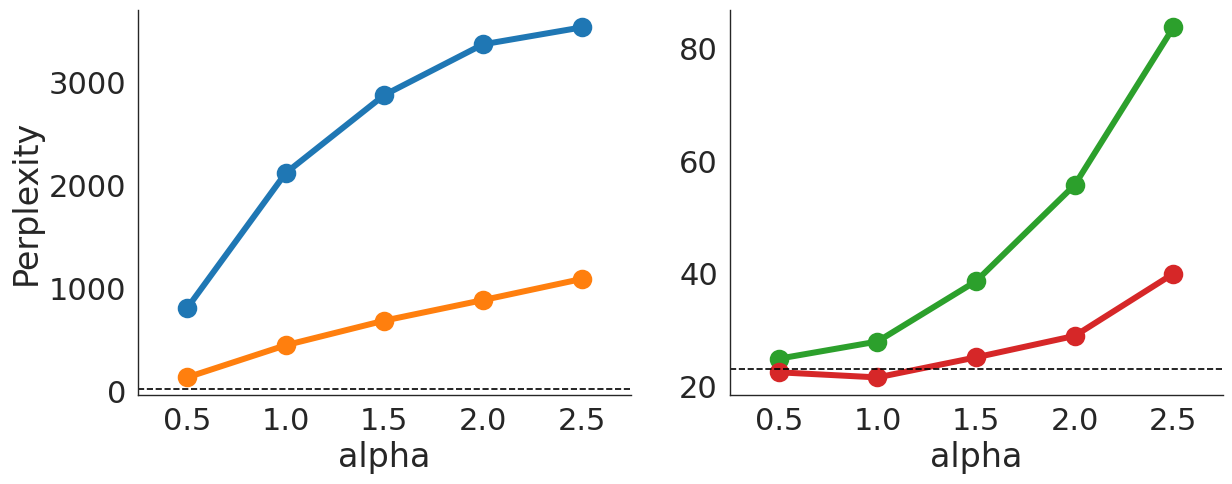

In [53]:
temp = metrics_dfs["perplexity"].query("dstore != 'Baseline'").copy()
baseline = metrics_dfs["perplexity"].query("mode == 'nontoxic' and dstore == 'Baseline'").copy()

for dstore in ["Toxic", "Toxic + Non-Toxic"]:
    fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
    temp2 = temp.query("dstore == @dstore and temperature < 50")
    g = sns.pointplot(
        data=temp2, 
        x="alpha", 
        y="value", 
        hue="temperature",
        scale=2.0,
        ax=axes[0]
    )
    g.set_ylabel("Perplexity")
    g.legend_.remove()
    value = baseline["value"].values[0]
    g.axhline(value, linestyle="--", color="black", label="GPT2 (large)")
    plt.grid(axis="y")

    g = sns.pointplot(
        data=temp.query("dstore == @dstore and temperature >= 50"), 
        x="alpha", 
        y="value", 
        hue="temperature",
        scale=2.0,
        ax=axes[1],
        palette=sns.color_palette('tab10')[temp2.temperature.nunique():]
    )
    g.axhline(value, linestyle="--", color="black", label="GPT2 (large)")

    g.legend_.remove()
    g.set_ylabel("")
    plt.grid(axis="y")
    sns.despine(right=True, top=True)
    plt.savefig(f"images/alpha_temperature_perplexity_{dstore.replace('+', '_').replace(' ', '_')}.pdf", bbox_inches="tight")
    fig.show()

<Figure size 700x500 with 0 Axes>

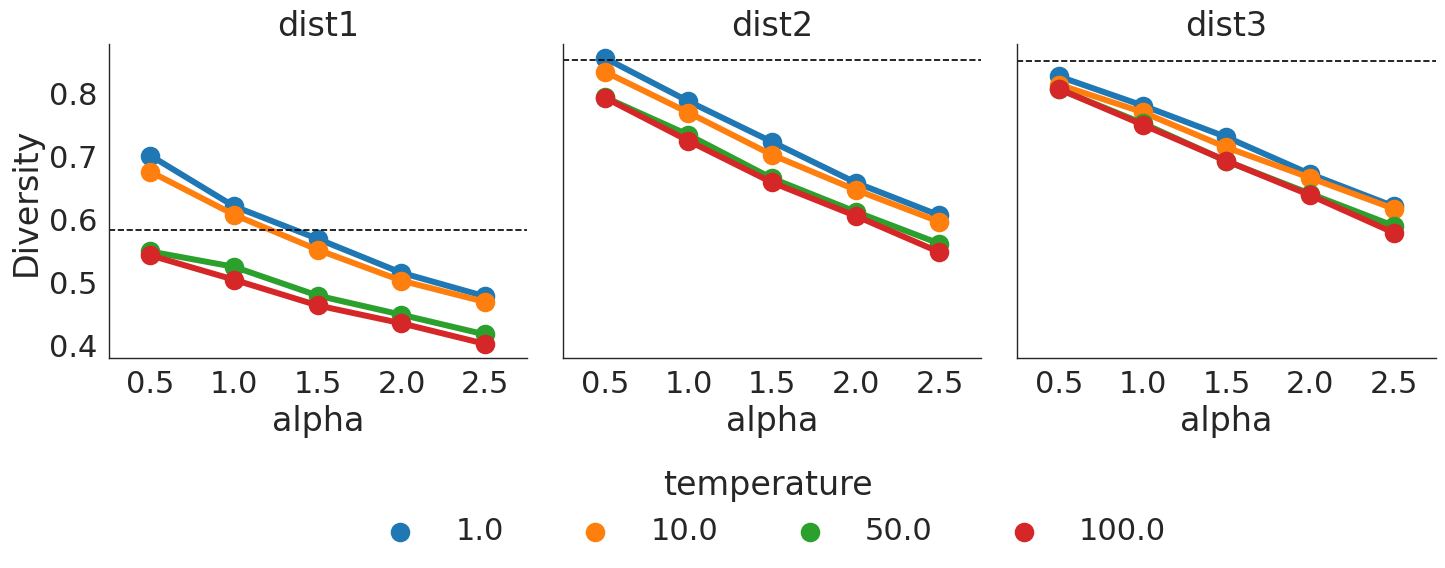

<Figure size 700x500 with 0 Axes>

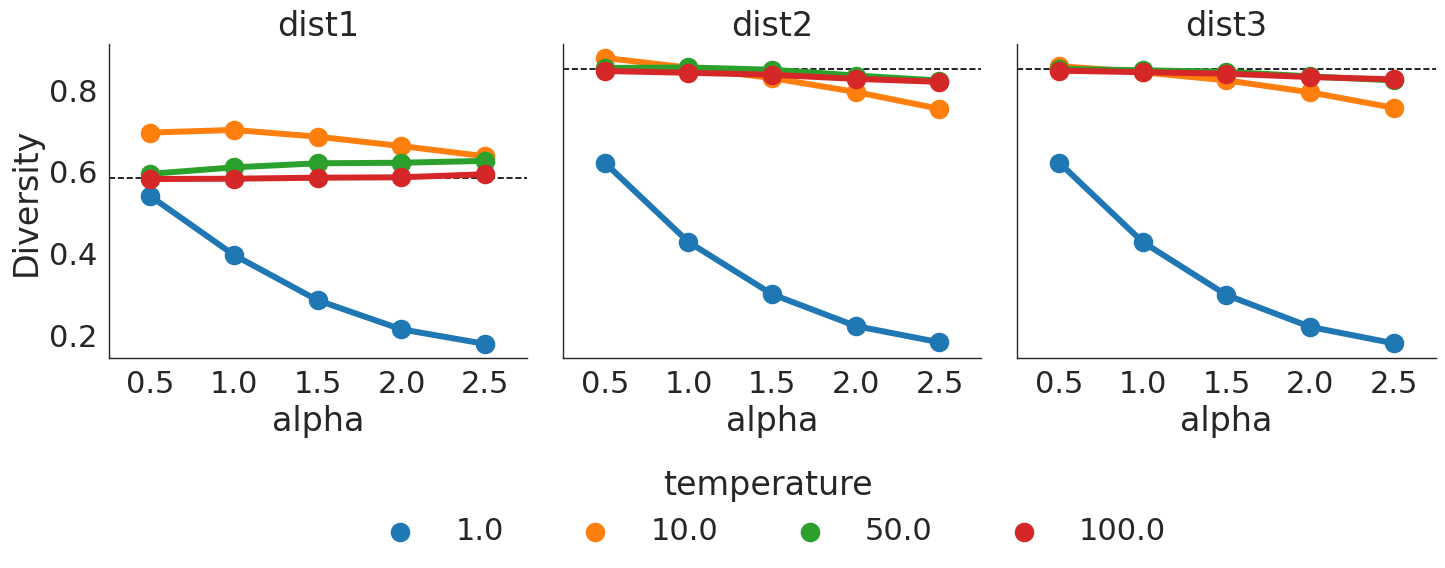

In [65]:
temp = metrics_dfs["diversity"].query("dstore != 'Baseline'").copy()
baseline = metrics_dfs["diversity"].query("dstore == 'Baseline'").copy()

for dstore in ["Toxic", "Toxic + Non-Toxic"]:
    plt.figure(figsize=(7, 5))
    g = sns.catplot(
        data=temp.query("dstore == @dstore"), 
        x="alpha", 
        y="value", 
        col="mode",
        hue="temperature",
        kind="point",
        scale=2.0
    )
    # g.legend.remove()
    g.set_titles("{col_name}")
    for ax, metric in zip(g.axes.flat, ["dist1", "dist2", "dist3"]):
        if metric == "dist1":
            ax.set_ylabel("Diversity")
        value = baseline[baseline["mode"] == metric]["value"].values[0]
        ax.axhline(value, linestyle="--", color="black", label="GPT2 (large)")
    # plt.legend(frameon=True, bbox_to_anchor=(1.7, 0.8), title="temperature", fontsize=18)
    sns.move_legend(g, loc="lower center", ncols=4, bbox_to_anchor=(0.47, -0.2))
    plt.savefig(f"images/alpha_temperature_diversity_{dstore.replace('+', '_').replace(' ', '_')}.pdf", bbox_inches="tight")
    plt.show()

## Datastore size

In [4]:
experiment_folder = base_folder / 'datastore_size/gpt2-large'
assert experiment_folder.exists()

metrics = ["perplexity", "diversity", "toxicity"]

metrics_dfs = {}
partition = "nontoxic"  # metric partition
for metric in metrics:
    files = list(experiment_folder.rglob(f"*{metric}.csv"))
    metric_df = pd.DataFrame()
    for file in files:
        df = pd.read_csv(file, index_col=0)
        param_series = pd.DataFrame(dict([sec.split("=") for sec in file.parent.stem.split("_")]), index=[file.parent.stem])
        
        if metric == "toxicity":
            df = df[partition]
            df.name = file.parent.stem
            df = df.to_frame().T.rename(
                columns={"avg_max": "Expected Maximum Toxicity", "toxicity_probability": "Toxicity Probability"})
            df["partition"] = partition

        if metric == "perplexity":
            df = df.rename(columns={partition: "perplexity"}, index={"perplexity": file.parent.stem})

        if metric == "diversity":
            df = df.rename(index={0: file.parent.stem})

        df = pd.concat([param_series, df], axis=1)
        metric_df = pd.concat([metric_df, df.reset_index()])

    metrics_dfs[metric] = metric_df.reset_index(drop=True)

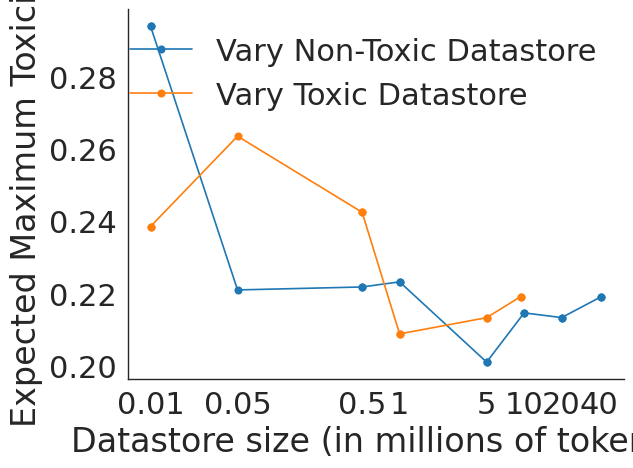

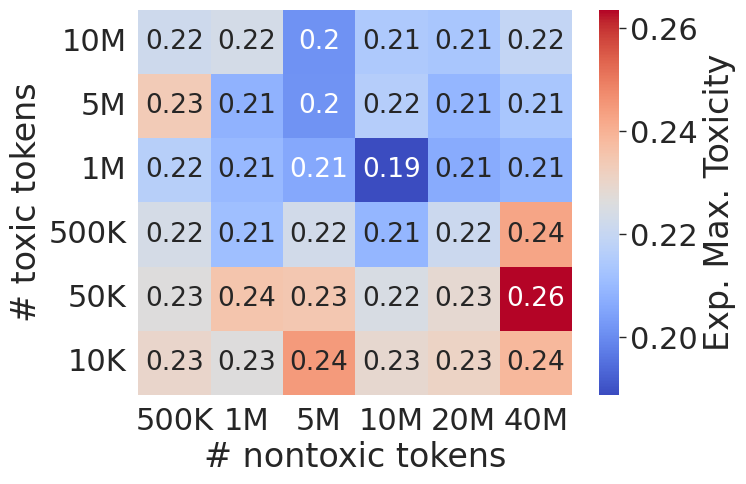

In [7]:
metric = "Expected Maximum Toxicity"
temp = metrics_dfs["toxicity"].copy()
temp["toxic"] = temp["toxic"].replace({"None": 9378564}).astype(int)
temp["nontoxic"] = temp["nontoxic"].replace({"None": 41737133}).astype(int)

vary_nontoxic = temp.query("toxic == 9378564").copy().sort_values("nontoxic")
vary_toxic = temp.query("nontoxic == 41737133").copy().sort_values("toxic")

plt.plot(
    vary_nontoxic["nontoxic"].values, 
    vary_nontoxic[metric].values,
    marker="o",
    label="Vary Non-Toxic Datastore"
)
plt.plot(
    vary_toxic["toxic"].values, 
    vary_toxic[metric].values,
    marker="o",
    label="Vary Toxic Datastore"
)
plt.xscale("log")
plt.ylabel(metric)
plt.xlabel("Datastore size (in millions of tokens)")
plt.xticks(
    ticks=[10_000, 50_000, 500_000, 1_000_000, 5_000_000, 10_000_000, 20_000_000, 40_000_000], 
    labels=[0.01, 0.05, 0.5, 1, 5, 10, 20, 40])
plt.legend(frameon=False)
sns.despine(right=True, top=True)
plt.savefig(f"images/exp_ds_size_{metric.lower().replace(' ', '_')}.pdf")
plt.show()

temp = pd.pivot_table(
    temp[["toxic", "nontoxic", metric]],
    values=[metric],
    index="toxic",
    columns=["nontoxic"]
).droplevel(0, axis=1).drop([10000, 50000], axis=1)

plt.figure(figsize=(7, 5))
sns.heatmap(temp[::-1], annot=True, cmap="coolwarm", cbar_kws={"label": "Exp. Max. Toxicity"}, annot_kws={"fontsize": 19})
plt.xlabel("# nontoxic tokens")
plt.ylabel("# toxic tokens")
plt.xticks(ticks=plt.xticks()[0], labels=['500K', '1M', '5M', '10M', '20M', '40M'], rotation=0)
plt.yticks(ticks=plt.yticks()[0], labels=['10K', '50K', '500K', '1M', '5M', '10M'][::-1])
plt.savefig(f"images/exp_ds_size_{metric.lower().replace(' ', '_')}_heatmap.pdf", bbox_inches="tight")
plt.savefig(f"images/exp_ds_size_{metric.lower().replace(' ', '_')}_heatmap.svg", format="svg", bbox_inches="tight")

plt.show()

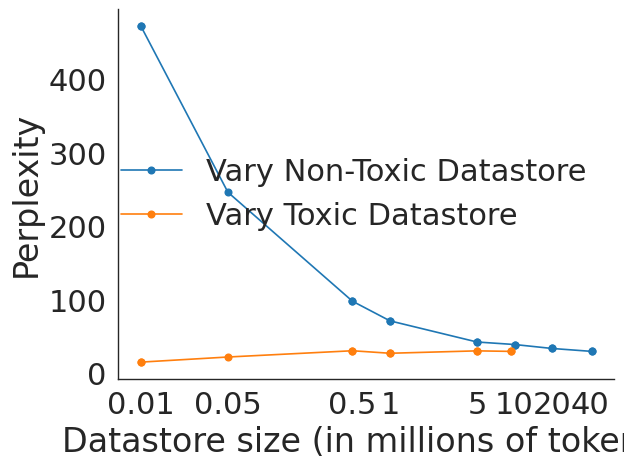

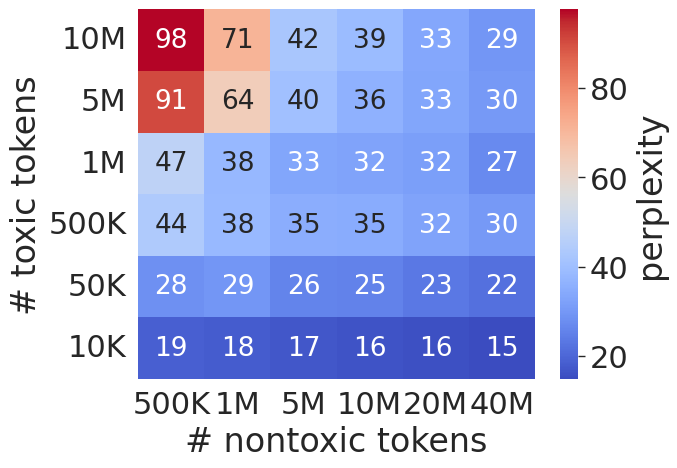

In [8]:
metric = "perplexity"
temp = metrics_dfs["perplexity"].copy()
temp["toxic"] = temp["toxic"].replace({"None": 9378564}).astype(int)
temp["nontoxic"] = temp["nontoxic"].replace({"None": 41737133}).astype(int)

vary_nontoxic = temp.query("toxic == 9378564").copy().sort_values("nontoxic")
vary_toxic = temp.query("nontoxic == 41737133").copy().sort_values("toxic")

plt.plot(
    vary_nontoxic["nontoxic"].values, 
    vary_nontoxic["perplexity"].values,
    marker="o",
    label="Vary Non-Toxic Datastore"
)
plt.plot(
    vary_toxic["toxic"].values, 
    vary_toxic["perplexity"].values,
    marker="o",
    label="Vary Toxic Datastore"
)
plt.xscale("log")
plt.ylabel("Perplexity")
plt.xlabel("Datastore size (in millions of tokens)")
plt.xticks(
    ticks=[10_000, 50_000, 500_000, 1_000_000, 5_000_000, 10_000_000, 20_000_000, 40_000_000], 
    labels=[0.01, 0.05, 0.5, 1, 5, 10, 20, 40])
plt.legend(frameon=False)
sns.despine(right=True, top=True)
plt.savefig(f"images/exp_ds_size_{metric.lower().replace(' ', '_')}.pdf")
plt.show()

temp = pd.pivot_table(
    temp[["toxic", "nontoxic", metric]].query("nontoxic > 50000"),
    values=[metric],
    index="toxic",
    columns=["nontoxic"]
).droplevel(0, axis=1)

sns.heatmap(temp[::-1], annot=True, cmap="coolwarm", cbar_kws={"label": metric}, annot_kws={"fontsize": 19})
plt.xlabel("# nontoxic tokens")
plt.ylabel("# toxic tokens")
plt.xticks(ticks=plt.xticks()[0], labels=['500K', '1M', '5M', '10M', '20M', '40M'], rotation=0)
plt.yticks(ticks=plt.yticks()[0], labels=['10K', '50K', '500K', '1M', '5M', '10M'][::-1])
plt.savefig(f"images/exp_ds_size_{metric.lower().replace(' ', '_')}_heatmap.pdf", bbox_inches="tight")
plt.savefig(f"images/exp_ds_size_{metric.lower().replace(' ', '_')}_heatmap.svg", format="svg", bbox_inches="tight")
plt.show()

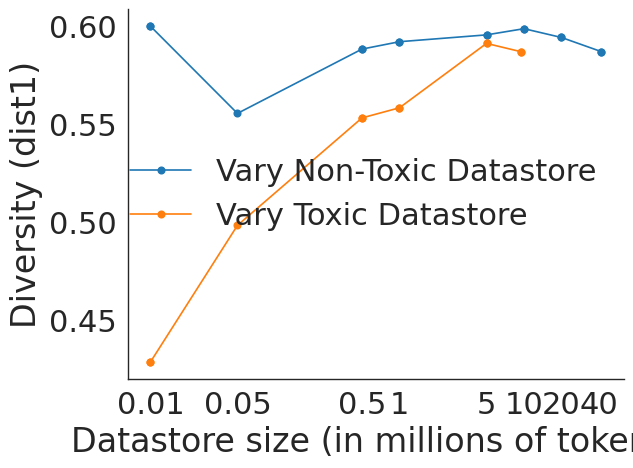

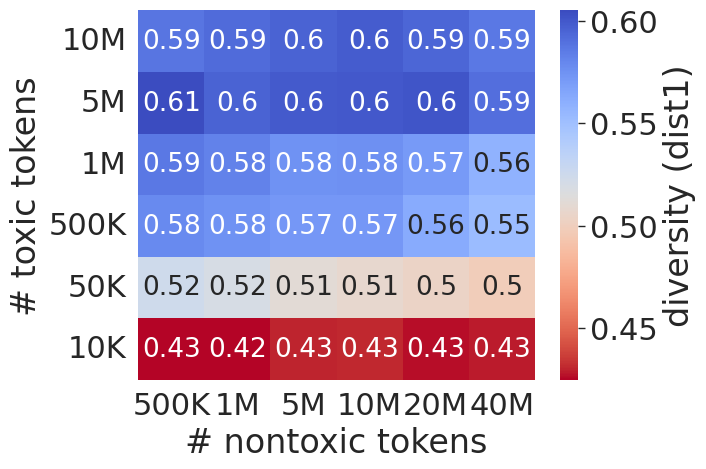

In [9]:
metric = "dist1"

temp = metrics_dfs["diversity"].copy()
temp["toxic"] = temp["toxic"].replace({"None": 9378564}).astype(int)
temp["nontoxic"] = temp["nontoxic"].replace({"None": 41737133}).astype(int)

vary_nontoxic = temp.query("toxic == 9378564").copy().sort_values("nontoxic")
vary_toxic = temp.query("nontoxic == 41737133").copy().sort_values("toxic")

plt.plot(
    vary_nontoxic["nontoxic"].values, 
    vary_nontoxic[metric].values,
    marker="o",
    label="Vary Non-Toxic Datastore"
)
plt.plot(
    vary_toxic["toxic"].values, 
    vary_toxic[metric].values,
    marker="o",
    label="Vary Toxic Datastore"
)
plt.xscale("log")
plt.ylabel(f"Diversity ({metric})")
plt.xlabel("Datastore size (in millions of tokens)")
plt.xticks(
    ticks=[10_000, 50_000, 500_000, 1_000_000, 5_000_000, 10_000_000, 20_000_000, 40_000_000], 
    labels=[0.01, 0.05, 0.5, 1, 5, 10, 20, 40])
plt.legend(frameon=False)
sns.despine(right=True, top=True)
plt.savefig(f"images/exp_ds_size_{metric.lower().replace(' ', '_')}.pdf")
plt.show()

temp = pd.pivot_table(
    temp[["toxic", "nontoxic", metric]],
    values=[metric],
    index="toxic",
    columns=["nontoxic"]
).droplevel(0, axis=1).drop([10000, 50000], axis=1)

sns.heatmap(temp[::-1], annot=True, cmap="coolwarm_r", cbar_kws={"label": f"diversity ({metric})"}, annot_kws={"fontsize": 19})
plt.xlabel("# nontoxic tokens")
plt.ylabel("# toxic tokens")
plt.xticks(ticks=plt.xticks()[0], labels=['500K', '1M', '5M', '10M', '20M', '40M'], rotation=0)
plt.yticks(ticks=plt.yticks()[0], labels=['10K', '50K', '500K', '1M', '5M', '10M'][::-1])
plt.savefig(f"images/exp_ds_size_{metric.lower().replace(' ', '_')}_heatmap.pdf", bbox_inches="tight")
plt.savefig(f"images/exp_ds_size_{metric.lower().replace(' ', '_')}_heatmap.svg", format="svg", bbox_inches="tight")
plt.show()

In [ ]:
compiled = pd.read_csv(experiment_folder / "compiled.csv", index_col=["Model"])
toxic_only = compiled.loc["Goodtriver - Toxic Only - Large"].copy()
compiled = compiled.drop(labels="Goodtriver - Toxic Only - Large")

compiled = compiled.replace({"-": np.nan})
compiled["# Tokens Toxic"] = compiled["# Tokens Toxic"].apply(lambda x: x.replace(",", "")).astype(float)
compiled["# Tokens Non-Toxic"] = compiled["# Tokens Non-Toxic"].apply(lambda x: x.replace(",", "")).astype(float)

In [ ]:
compiled["Total Train Toxic (h)"] = compiled[["Toxic Build (s)", "Toxic Train (s)"]].astype(float).sum(axis=1) / 3600
compiled["Total Train Non-Toxic (h)"] = compiled[["Non-Toxic Build (s)", "Non-Toxic Train (s)"]].astype(float).sum(axis=1) / 3600
compiled["Total Train (h) "] = compiled[["Total Train Toxic (h)", "Total Train Non-Toxic (h)"]].sum(axis=1)

In [ ]:
columns = ["# Tokens Toxic", "# Tokens Non-Toxic", "Inference Time (s)"] + compiled.filter(like="Total Train").columns.tolist()
compiled[columns]

# Tokens Toxic  \
Model                           Mode                                             
Goodtriever - Large             Baseline (best)                           Full   
                                Vary Toxic                              10,000   
                                Vary Toxic                             500,000   
                                Vary Toxic                           1,000,000   
                                Vary Toxic                           5,000,000   
                                Vary Non-Toxic                            Full   
                                Vary Non-Toxic                            Full   
                                Vary Non-Toxic                            Full   
                                Vary Non-Toxic                            Full   
                                Vary Non-Toxic                            Full   
                                Vary Non-Toxic                            Full   
                                Vary both        Not feeling this is necessary   
Goodtriver - Toxic Only - Large Vary Toxic                              10,000   
                                Vary Toxic                             500,000   
                                Vary Toxic                           1,000,000   
                                Vary Toxic                           5,000,000   
                                Vary Toxic                                Full   

                                                # Tokens Non-Toxic  \
Model                           Mode                                 
Goodtriever - Large             Baseline (best)               Full   
                                Vary Toxic                    Full   
                                Vary Toxic                    Full   
                                Vary Toxic                    Full   
                                Vary Toxic                    Full   
                                Vary Non-Toxic              10,000   
                                Vary Non-Toxic             500,000   
                                Vary Non-Toxic           1,000,000   
                                Vary Non-Toxic           5,000,000   
                                Vary Non-Toxic          10,000,000   
                                Vary Non-Toxic          20,000,000   
                                Vary both                      NaN   
Goodtriver - Toxic Only - Large Vary Toxic              GPT2 Large   
                                Vary Toxic              GPT2 Large   
                                Vary Toxic              GPT2 Large   
                                Vary Toxic              GPT2 Large   
                                Vary Toxic              GPT2 Large   

                                                Inference Time (s)  \
Model                           Mode                                 
Goodtriever - Large             Baseline (best)    0.01402 (0.025)   
                                Vary Toxic         0.01394 (0.025)   
                                Vary Toxic         0.01381 (0.024)   
                                Vary Toxic         0.01392 (0.025)   
                                Vary Toxic         0.01391 (0.025)   
                                Vary Non-Toxic     0.01328 (0.024)   
                                Vary Non-Toxic     0.01325 (0.023)   
                                Vary Non-Toxic     0.01313 (0.023)   
                                Vary Non-Toxic     0.01323 (0.023)   
                                Vary Non-Toxic     0.01329 (0.024)   
                                Vary Non-Toxic     0.01345 (0.024)   
                                Vary both                      NaN   
Goodtriver - Toxic Only - Large Vary Toxic                     NaN   
                                Vary Toxic                     NaN   
                                Vary Toxic            

## K Neighbors

In [10]:
experiment_folder = base_folder / 'k'
assert experiment_folder.exists()

metrics = ["perplexity", "diversity", "toxicity"]

metrics_dfs = {}
partition = "nontoxic"  # metric partition
for metric in metrics:
    files = list(experiment_folder.rglob(f"*{metric}.csv"))
    metric_df = pd.DataFrame()
    for file in files:
        df = pd.read_csv(file, index_col=0)
        param_series = pd.DataFrame(dict([sec.split("=") for sec in file.parent.stem.split("_")]), index=[file.parent.stem])
        
        if metric == "toxicity":
            df = df[partition]
            df.name = file.parent.stem
            df = df.to_frame().T.rename(
                columns={"avg_max": "Expected Maximum Toxicity", "toxicity_probability": "Toxicity Probability"})
            df["partition"] = partition

        if metric == "perplexity":
            df = df.rename(columns={partition: "perplexity"}, index={"perplexity": file.parent.stem})

        if metric == "diversity":
            df = df.rename(index={0: file.parent.stem})

        df = pd.concat([param_series, df], axis=1)
        metric_df = pd.concat([metric_df, df.reset_index()])

    metrics_dfs[metric] = metric_df.reset_index(drop=True)

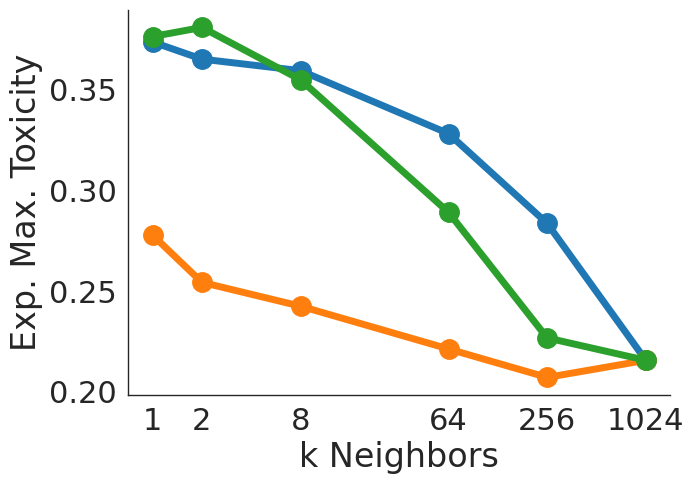

In [23]:
metric = "Expected Maximum Toxicity"
temp = metrics_dfs["toxicity"].copy()
temp[["ktoxic", "knontoxic"]] = temp[["ktoxic", "knontoxic"]].astype(float)

vary_nontoxic = temp.query("ktoxic == 1024").copy().sort_values("knontoxic")
vary_toxic = temp.query("knontoxic == 1024").copy().sort_values("ktoxic")
vary_both = temp.query("ktoxic == knontoxic").copy().sort_values("knontoxic")

linewidth = 5
markersize = 14
plt.figure(figsize=(7,5))
plt.plot(
    vary_nontoxic["knontoxic"].values, 
    vary_nontoxic[metric].values,
    marker="o",
    label="Non-Toxic",
    linewidth=linewidth,
    markersize=markersize,
)
plt.plot(
    vary_toxic["ktoxic"].values, 
    vary_toxic[metric].values,
    marker="o",
    label="Toxic",
    linewidth=linewidth,
    markersize=markersize,
)
plt.plot(
    vary_both["ktoxic"].values, 
    vary_both[metric].values,
    marker="o",
    label="Both",
    linewidth=linewidth,
    markersize=markersize,
)
plt.xscale("log", base=2)
plt.ylabel("Exp. Max. Toxicity")
plt.xlabel("k Neighbors")
plt.xticks(ticks=[1, 2, 8, 64, 256, 1024], labels=[1, 2, 8, 64, 256, 1024], rotation=0)
# plt.legend(frameon=False, title="Varied Datastore", bbox_to_anchor=(0.7, 1.0))
sns.despine(right=True, top=True)
plt.savefig(f"images/exp_k_neighbors_{metric.lower().replace(' ', '_')}.pdf", bbox_inches="tight")
plt.show()

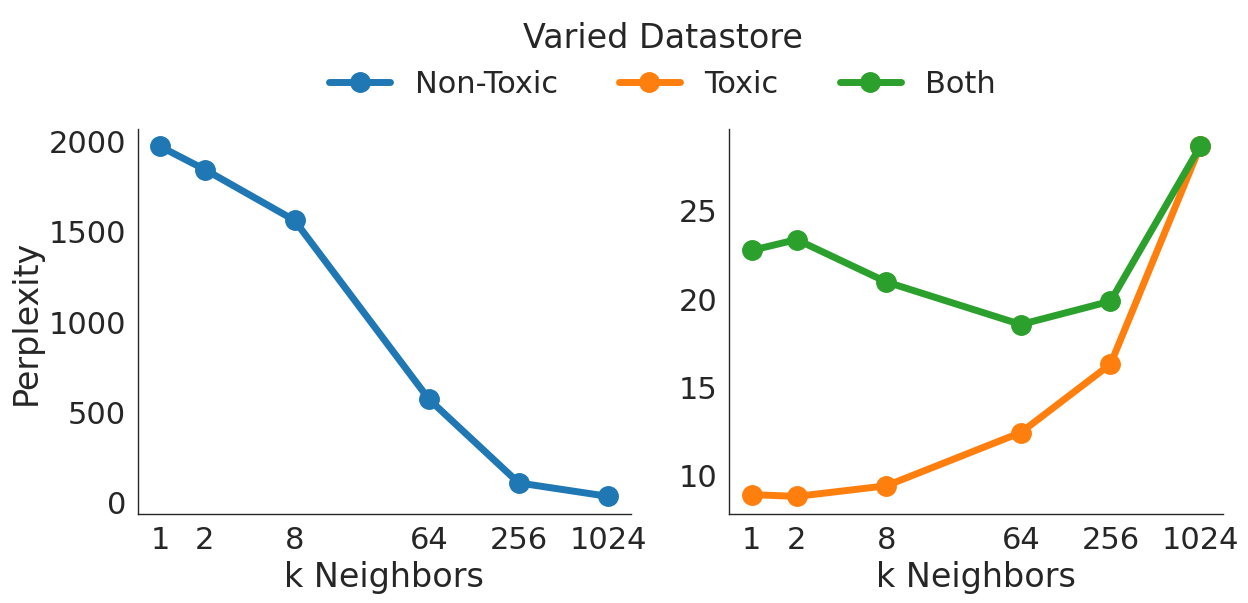

In [39]:
metric = "perplexity"

temp = metrics_dfs["perplexity"].copy()
temp[["ktoxic", "knontoxic"]] = temp[["ktoxic", "knontoxic"]].astype(float)

vary_nontoxic = temp.query("ktoxic == 1024").copy().sort_values("knontoxic")
vary_toxic = temp.query("knontoxic == 1024").copy().sort_values("ktoxic")
vary_both = temp.query("ktoxic == knontoxic").copy().sort_values("knontoxic")

fig, axes = plt.subplots(ncols=2, figsize=(14,5), sharex=True)

axes[0].plot(
    vary_nontoxic["knontoxic"].values, 
    vary_nontoxic[metric].values,
    marker="o",
    label="Non-Toxic",
    linewidth=linewidth,
    markersize=markersize,
    color=sns.color_palette('tab10')[0]
)
axes[0].set_ylabel(metric.capitalize())
axes[0].set_xticks(ticks=[1, 2, 8, 64, 256, 1024], labels=[1, 2, 8, 64, 256, 1024], rotation=0)
axes[1].plot(
    vary_toxic["ktoxic"].values, 
    vary_toxic[metric].values,
    marker="o",
    label="Toxic",
    linewidth=linewidth,
    markersize=markersize,
    color=sns.color_palette('tab10')[1]
)
axes[1].plot(
    vary_both["ktoxic"].values, 
    vary_both[metric].values,
    marker="o",
    label="Both",
    linewidth=linewidth,
    markersize=markersize,
    color=sns.color_palette('tab10')[2]
)
plt.xscale("log", base=2)
axes[0].set_xlabel("k Neighbors")
axes[1].set_xlabel("k Neighbors")
plt.xticks(ticks=[1, 2, 8, 64, 256, 1024], labels=[1, 2, 8, 64, 256, 1024], rotation=0)
fig.legend(frameon=False, title="Varied Datastore")

sns.despine(right=True, top=True)
sns.move_legend(fig, loc="upper center", ncols=3, bbox_to_anchor=(0.5, 1.15))
plt.savefig(f"images/exp_k_neighbors_{metric.lower().replace(' ', '_')}.pdf", bbox_inches="tight")
plt.show()

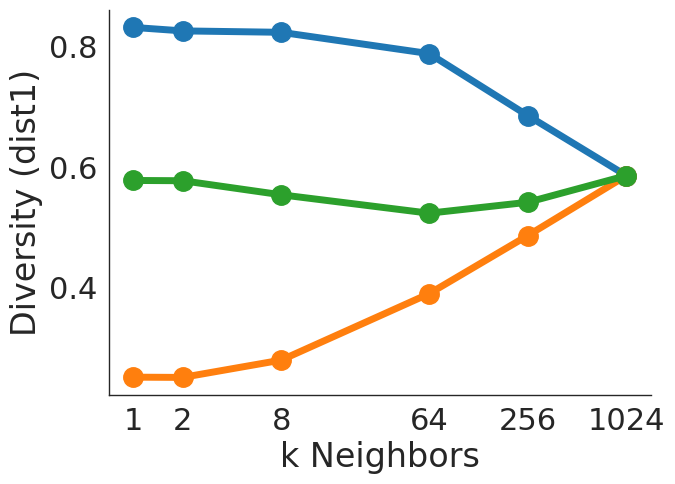

In [20]:
metric = "dist1"

temp = metrics_dfs["diversity"].copy()
temp[["ktoxic", "knontoxic"]] = temp[["ktoxic", "knontoxic"]].astype(float)

vary_nontoxic = temp.query("ktoxic == 1024").copy().sort_values("knontoxic")
vary_toxic = temp.query("knontoxic == 1024").copy().sort_values("ktoxic")
vary_both = temp.query("ktoxic == knontoxic").copy().sort_values("knontoxic")

plt.figure(figsize=(7,5))
plt.plot(
    vary_nontoxic["knontoxic"].values, 
    vary_nontoxic[metric].values,
    marker="o",
    label="Non-Toxic",
    linewidth=linewidth,
    markersize=markersize,
)
plt.plot(
    vary_toxic["ktoxic"].values, 
    vary_toxic[metric].values,
    marker="o",
    label="Toxic",
    linewidth=linewidth,
    markersize=markersize,
)
plt.plot(
    vary_both["ktoxic"].values, 
    vary_both[metric].values,
    marker="o",
    label="Both",
    linewidth=linewidth,
    markersize=markersize,
)
plt.xscale("log", base=2)
plt.ylabel(f"Diversity ({metric})")
plt.xlabel("k Neighbors")
plt.xticks(ticks=[1, 2, 8, 64, 256, 1024], labels=[1, 2, 8, 64, 256, 1024], rotation=0)
# plt.legend(frameon=True, title="Varied Datastore", bbox_to_anchor=(1.0, 1.0), fontsize=18)
sns.despine(right=True, top=True)
plt.savefig(f"images/exp_k_neighbors_{metric.lower().replace(' ', '_')}.pdf", bbox_inches="tight")
plt.show()